In [7]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras
import utils 
from importlib import reload 
print(tf.__version__)

2.3.0


In [8]:
N=100 # time disrectization    
m = 1 # dimension of price
S0 = 1 # initial value of the asset
T=1 # maturity
strike = 1.0
  
# option_type = 'eurocall'
option_type = 'eurodigitalcall'

if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

### Generate price paths of Black-Scholes model
$$
S_{t} = S_{0}e^{\sigma W_{t} - \frac{\sigma^{2}}{2}t}
$$

$$
a_{0}, a_{0}q, \cdots, a_{0}q^{N-1}
$$

$$
\sum_{n=1}^{N}a_{0}q^{n-1} = a_{0}\frac{q^{N}-1}{q-1} = T
$$

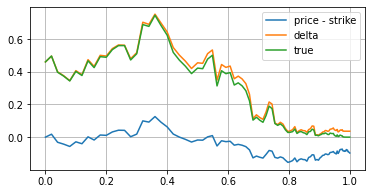

In [9]:
reload(utils)
# GBM
sigma=0.2 # volatility in Black Scholes  
Ktrain = 10**5
# price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,sigma,S0,'exp')
price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,sigma,S0,'equi-exp')
payoff = payoff_function(price_path[:,-1,:]) 
delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff,T,strike,sigma,option_type,time_grid)

# plt.plot(np.diff(time_grid))
# plt.xlabel('rebalancing time')
for i in range(1):
    plt.figure(figsize = [6,3])
    plt.plot(time_grid, price_path[i,:,0].T - S0, label = 'price - strike')
    plt.plot(time_grid, delta_path[i,:,0].T, label = 'delta')
    plt.plot(time_grid, option_path[i,:,0].T, label = 'true')
    plt.legend()
    plt.grid()
    plt.show()

### Build the deep hedging dynamic 
Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad & E\bigg[(f(S_{T})-V_{T})^2\bigg] \\
+ &\beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}\\
+ &\alpha E\bigg[\int_{0}^{t}(S_{t}dH_{t})^{2}\bigg] \cdot \text{(control_trans_cost =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function.

In [10]:
def build_dynamic(m, N, control_path, control_trans_cost, trans_cost):
    
    d = 3 # number of layers in strategy
    n = 32  # nodes in the first but last layers
    Networks = utils.build_network(m, n , d, N)
    Network0 = keras.layers.Dense(m, use_bias=False)
    
    # Non-recurrent structure

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    if control_path:
        inputs = [price,benchmark_hedge]
    else:
        inputs = price
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
    premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    for j in range(N):
        STRATEGY[j] = Networks[j](price[:,j,:])  # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost: 
            if j > 0:
                cost = 0.005*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
    outputs = premium + HEDGE[-1] # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)
    
    mse = tf.keras.losses.MeanSquaredError()
    if control_path:
        for j in range(N):
            model_hedge.add_loss(10*mse(HEDGE[j]+premium, benchmark_hedge[:,j]))
            
    if control_trans_cost:
        for j in range(N):
            if j > 0:
                model_hedge.add_loss(0.005*mse(STRATEGY[j]*price[:,j,:], STRATEGY[j-1]*price[:,j,:]))
                
    return model_hedge, Networks, Network0


In [11]:
class Model_hedge:
    def __init__(self, m, N, control_path, control_trans_cost, trans_cost):
        self.m = m
        self.N = N
        self.control_path = control_path
        self.control_trans_cost = control_trans_cost
        self.trans_cost = trans_cost
        self.model, self.Networks, self.Network0 = build_dynamic(m, N, control_path, control_trans_cost, trans_cost)   
    def prepare_data(self, price_path, option_path, payoff):
        self.price_path = price_path
        self.payoff = payoff
        if not self.control_path:
            option_path = price_path
        Ktrain = price_path.shape[0]
        split = int(Ktrain/2)
        self.split = split
        self.xtrain = [price_path[:split],option_path[:split]]  
        self.ytrain = payoff[:split]
        self.xtest = [price_path[split:],option_path[split:]] 
        self.ytest = payoff[split:]  
    def train(self, epochs, verbose):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # specify the optmizer 
        self.model.compile(optimizer = optimizer, loss='mse') # specify the mean square loss 
        self.model.fit(x=self.xtrain,y=self.ytrain, epochs=epochs,verbose=verbose,batch_size=1000) # train the model 
    def predict(self):
        self.hedge_output_train = self.model.predict(self.xtrain) 
        self.hedge_output_test = self.model.predict(self.xtest) 
        return self.hedge_output_train, self.hedge_output_test
    def plot(self,price_path, payoff, delta_output):
        split = self.split
        f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
        p[0].scatter(price_path[split:,-1,0], self.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
        p[1].scatter(price_path[:split,-1,0], self.hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
        p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
        for i in range(3):
            p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
            p[i].legend()
            p[i].grid()
        plt.show()
        
        

In [12]:
def trans_cost_compute(Networks):
    Hedge = [None] * N
    transaction_cost = 0
    for j in range(N):
        Hedge[j] = Networks[j](price_path[:,j,:])
        if j > 0: 
            transaction_cost += 0.005*(Hedge[j]*price_path[:,j-1,:] - Hedge[j-1]*price_path[:,j-1,:])**2
    print('transaction cost: ', transaction_cost[:,0].numpy().mean())
#     plt.hist(transaction_cost[:,0].numpy())
#     plt.show()

control_path:  False
control_trans_cost:  False
trans_cost:  False
Building model ... 
Preparing data ... 
Training ... 
Epoch 1/20
50/50 [==============================] - 3s 66ms/step - loss: 0.4109
Epoch 2/20
50/50 [==============================] - 3s 58ms/step - loss: 0.1319
Epoch 3/20
50/50 [==============================] - 3s 66ms/step - loss: 0.0934
Epoch 4/20
50/50 [==============================] - 3s 60ms/step - loss: 0.0868
Epoch 5/20
50/50 [==============================] - 3s 62ms/step - loss: 0.0783
Epoch 6/20
50/50 [==============================] - 3s 59ms/step - loss: 0.0662
Epoch 7/20
50/50 [==============================] - 3s 57ms/step - loss: 0.0552
Epoch 8/20
50/50 [==============================] - 3s 66ms/step - loss: 0.0454
Epoch 9/20
50/50 [==============================] - 3s 63ms/step - loss: 0.0385
Epoch 10/20
50/50 [==============================] - 3s 65ms/step - loss: 0.0332: 1s - loss: - ETA: 0s -
Epoch 11/20
50/50 [==============================] - 3

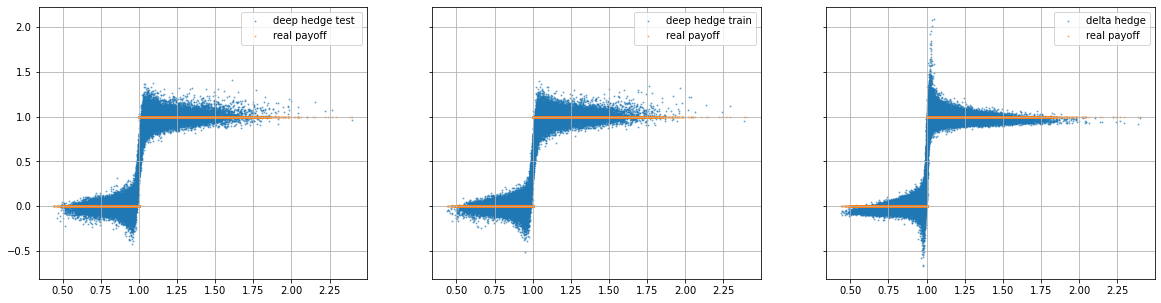

deep premium: 0.4605
real premium: 0.4602
control_path:  True
control_trans_cost:  False
trans_cost:  False
Building model ... 
Preparing data ... 
Training ... 
Epoch 1/20
50/50 [==============================] - 3s 60ms/step - loss: 440.2178
Epoch 2/20
50/50 [==============================] - 3s 55ms/step - loss: 95.4124
Epoch 3/20
50/50 [==============================] - 3s 59ms/step - loss: 29.9837
Epoch 4/20
50/50 [==============================] - 3s 55ms/step - loss: 20.6004
Epoch 5/20
50/50 [==============================] - 3s 54ms/step - loss: 13.9045
Epoch 6/20
50/50 [==============================] - 3s 57ms/step - loss: 7.9415
Epoch 7/20
50/50 [==============================] - 3s 52ms/step - loss: 4.7170
Epoch 8/20
50/50 [==============================] - 4s 80ms/step - loss: 3.1419
Epoch 9/20
50/50 [==============================] - 3s 53ms/step - loss: 2.3739
Epoch 10/20
50/50 [==============================] - 3s 53ms/step - loss: 1.8562: 0s 
Epoch 11/20
50/50 [=======

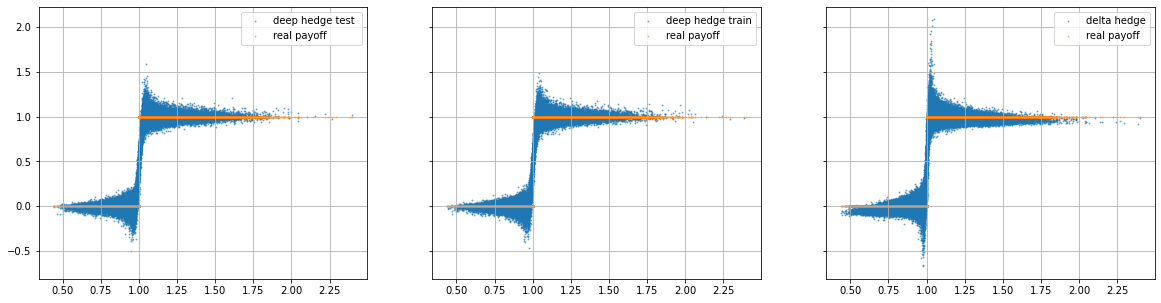

deep premium: 0.4604
real premium: 0.4602
control_path:  False
control_trans_cost:  False
trans_cost:  True
Building model ... 
Preparing data ... 
Training ... 
Epoch 1/20
50/50 [==============================] - 3s 59ms/step - loss: 0.2358: 0s - los
Epoch 2/20
50/50 [==============================] - 3s 61ms/step - loss: 0.0914
Epoch 3/20
50/50 [==============================] - 3s 58ms/step - loss: 0.0683
Epoch 4/20
50/50 [==============================] - 3s 64ms/step - loss: 0.0456: 0s - loss: 0
Epoch 5/20
50/50 [==============================] - 3s 64ms/step - loss: 0.0402
Epoch 6/20
50/50 [==============================] - 3s 57ms/step - loss: 0.0385
Epoch 7/20
50/50 [==============================] - 3s 54ms/step - loss: 0.0368
Epoch 8/20
50/50 [==============================] - 3s 51ms/step - loss: 0.0357
Epoch 9/20
50/50 [==============================] - 3s 52ms/step - loss: 0.0325
Epoch 10/20
50/50 [==============================] - 3s 54ms/step - loss: 0.0302: 1
Epoch 11/2

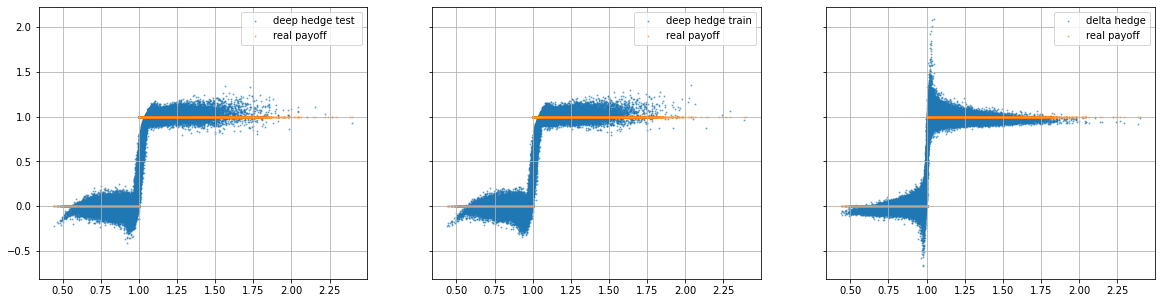

deep premium: 0.9378
real premium: 0.4602
transaction cost:  0.49798095
control_path:  True
control_trans_cost:  False
trans_cost:  True
Building model ... 
Preparing data ... 
Training ... 
Epoch 1/20
50/50 [==============================] - 3s 62ms/step - loss: 35.1030 0s - los
Epoch 2/20
50/50 [==============================] - 3s 65ms/step - loss: 19.5769
Epoch 3/20
50/50 [==============================] - 3s 69ms/step - loss: 17.1017
Epoch 4/20
50/50 [==============================] - 3s 67ms/step - loss: 15.7051
Epoch 5/20
50/50 [==============================] - 3s 66ms/step - loss: 14.0421
Epoch 6/20
50/50 [==============================] - 3s 65ms/step - loss: 11.6567
Epoch 7/20
50/50 [==============================] - 3s 65ms/step - loss: 9.1370
Epoch 8/20
50/50 [==============================] - 3s 61ms/step - loss: 6.7700
Epoch 9/20
50/50 [==============================] - 3s 62ms/step - loss: 5.1304
Epoch 10/20
50/50 [==============================] - 3s 62ms/step - loss: 

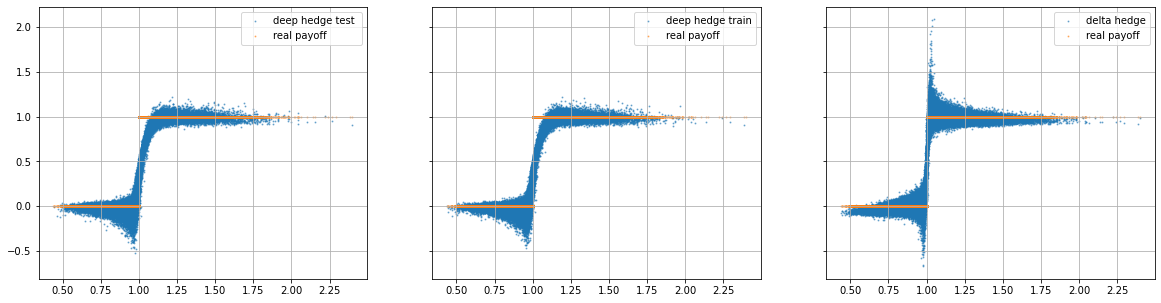

deep premium: 0.4824
real premium: 0.4602
transaction cost:  0.07968911


In [13]:
MODEL = []
control_trans_cost = False
for trans_cost in [False,True]:
    for control_path in [False,True]:
        print('control_path: ', control_path)
        print('control_trans_cost: ', control_trans_cost)
        print('trans_cost: ', trans_cost)
        print('Building model ... ')
        model_hedge = Model_hedge(m, N, control_path, control_trans_cost, trans_cost)
        print('Preparing data ... ')
        model_hedge.prepare_data(price_path,option_path,payoff)
        print('Training ... ')
        model_hedge.train(epochs = 20,verbose = True)
        print('Predicting ... ')
        model_hedge.predict()
        print('Ploting ... ')
        model_hedge.plot(price_path, payoff, delta_output)

        print(f"deep premium: {model_hedge.Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
        helper,_ = utils.BlackScholes(T, S0, strike, sigma, option_type)
        print(f"real premium: {helper:{1}.{4}}")           # real premium
        if trans_cost:
            trans_cost_compute(model_hedge.Networks)

        print('='*100)

        MODEL.append(model_hedge)
            

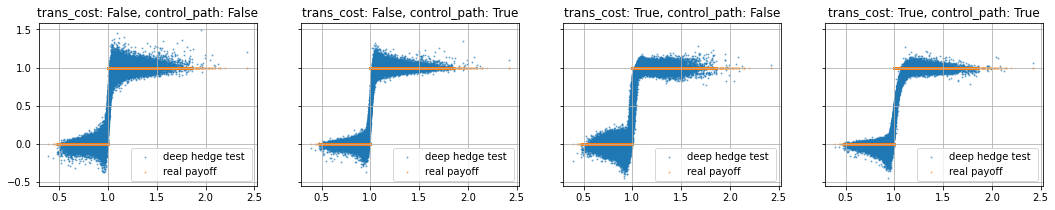

In [8]:
# Summary plot
f,p = plt.subplots(1,4, figsize = [18,3], sharey = True)
for i in range(4):
    model_hedge = MODEL[i]
    p[i].scatter(price_path[model_hedge.split:,-1,0], model_hedge.hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].title.set_text('trans_cost: ' + str(model_hedge.trans_cost) + ', control_path: ' + str(model_hedge.control_path))
    p[i].legend()
    p[i].grid()
plt.show()


In [ ]:
model_hedge = Model_hedge(m, N, control_path, control_trans_cost, trans_cost)
print('Preparing data ... ')
model_hedge.prepare_data(price_path,option_path,payoff)
print('Training ... ')
model_hedge.train(epochs = 20,verbose = True)
print('Predicting ... ')
model_hedge.predict()
print('Ploting ... ')
model_hedge.plot(price_path, payoff, delta_output)